In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout, Lambda
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
import os
from skimage import io
import scipy.ndimage as ndi
import scipy.signal as sig
from skimage import measure as sk
import glob
import datetime
import multiprocessing

In [2]:
def valueToIndex(list, value):
    index = np.abs(np.array(list) - value).argmin()
    return index

def findCenter(img, xSlice, ySlice, verbose): #original Slice values
#def findCenter(img, xSlice=0, ySlice=0, blur=30, verbose=True):
    # Apply median filter to get rid of noisy peaks
    Sauce = img
    #img = ndi.gaussian_filter(img, sigma=blur)
    #img = np.uint32(ndi.median_filter(img))

    # Find image dimensions
    xSize = img.shape[1] - 1
    ySize = img.shape[0] - 1

    # Define slice start points and end points
    x1, y1 = [0, xSize], [ySize / 2 + ySlice, ySize / 2 + ySlice]
    x2, y2 = [xSize / 2 + xSlice, xSize / 2 + xSlice], [0, ySize]

    # Take profile of image along slice
    xProfile = sk.profile_line(img, (y1[0], x1[0]), (y1[1], x1[1]), mode='reflect')
    yProfile = sk.profile_line(img, (y2[0], x2[0]), (y2[1], x2[1]), mode='reflect')
    # Assign xCenter and yCenter to position of maximum of profile
    xCenter = valueToIndex(xProfile, max(xProfile[500:680]))
    yCenter = valueToIndex(yProfile, max(yProfile[450:615]))
    print('Center(x,y):')    
    print(xCenter, yCenter)

    # Plot stuff if verbose is True
    if verbose:
        # Get max value for scaling.

        plt.imshow(Sauce, extent=[0, xSize, ySize, 0])
        plt.clim(0, 2000)

        plt.plot(x1, y1)
        plt.plot(x2, y2)
        plt.plot(xCenter, yCenter, marker='.')

        plt.gcf().gca().add_artist(plt.Circle((xCenter, yCenter), 150, fill=False))

        plt.plot(xProfile/max(xProfile)*500)
        plt.plot(yProfile/max(yProfile)*500)
        plt.show()

    return (xCenter, yCenter)

def cropImage(img, xCenter, yCenter, cropWidth):
    return img[yCenter - cropWidth:yCenter + cropWidth, xCenter - cropWidth:xCenter + cropWidth]

In [3]:
#This first function isn't used

def center_image(image, directory):
    
    testing_dir = 'D:\\Uni\\Year 3 Summer\\NSERC\\First_task_bismuth\\neural_net\\Testing\\' + directory + '\\'
    img_file = testing_dir + image
    
    img = np.array(Image.open(img_file))
    xCenter, yCenter = findCenter(img, 0, 0, False)
    centered_img = cropImage(img, xCenter, yCenter, 375)
    
    return centered_img


def preprocess_img(image, directory):
    
    """inputs the file location of the image, ouputs the image and its center coordinates"""
    
    testing_dir = 'D:\\Uni\\Year 3 Summer\\NSERC\\First_task_bismuth\\neural_net\\Testing\\' + directory + '\\'
    img_file = testing_dir + image
   
    img = np.array(Image.open(img_file)).astype(np.int16)
    xCenter, yCenter = findCenter(img, 0, 0, False)
    
    
    #resizing
    #onimg = np.array(Image.fromarray(onimg).resize((250,250))).astype(np.int16)
    
    return img, xCenter, yCenter

In [4]:
def radialProfile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int16)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr  # does this divide by number of pixels? Then it is truly average
    return radialprofile

In [5]:
pixel_to_s = 2.126e-3
scattering_scale = pixel_to_s * np.arange(815)

In [6]:
def B(T):
    
    """Inputs temperature, outputs the debye-waller factor of Bismuth"""
    a0 = 0.0361
    a1 = 0.358*(10**-2)
    a2 = 0.1111*(10**-5)
    a3 = -0.1855*(10**-8)
    a4 = 0.114*(10**-11)
    
    return a0 + (a1*T)+ (a2*(T**2)) + (a3*(T**3)) + (a4*(T**4)) 

def DB(T):
    """The derivative of B"""
    a1 = 0.358*(10**-2)
    a2 = 0.1111*(10**-5)
    a3 = -0.1855*(10**-8)
    a4 = 0.114*(10**-11)
    
    return a1 + (2*a2*T) + (3*a3*(T**2)) + (4*a4*(T**3))

def newton(f,Df,x0,epsilon,max_iter):
    '''Approximate solution of f(x)=0 by Newton's method.

    Parameters
    ----------
    f : function
        Function for which we are searching for a solution f(x)=0.
    Df : function
        Derivative of f(x).
    x0 : number
        Initial guess for a solution f(x)=0.
    epsilon : number
        Stopping criteria is abs(f(x)) < epsilon.
    max_iter : integer
        Maximum number of iterations of Newton's method.

    Returns
    -------
    xn : number
        Implement Newton's method: compute the linear approximation
        of f(x) at xn and find x intercept by the formula
            x = xn - f(xn)/Df(xn)
        Continue until abs(f(xn)) < epsilon and return xn.
        If Df(xn) == 0, return None. If the number of iterations
        exceeds max_iter, then return None.

    Examples
    --------
    >>> f = lambda x: x**2 - x - 1
    >>> Df = lambda x: 2*x - 1
    >>> newton(f,Df,1,1e-8,10)
    Found solution after 5 iterations.
    1.618033988749989
    '''
    xn = x0
    for n in range(0,max_iter):
        fxn = f(xn)
        if abs(fxn) < epsilon:
            print('Found solution after',n,'iterations.')
            return xn
        Dfxn = Df(xn)
        if Dfxn == 0:
            print('Zero derivative. No solution found.')
            return None
        xn = xn - fxn/Dfxn
    print('Exceeded maximum iterations. No solution found.')
    return None

def B_inverse(b):
    
    """Inputs Debye-Waller factor, outputs the temperature """
    
    def func(T):
        return B(T) - b
    
    root = newton(func, DB, 300, 0.0001, 500)
    
    return root

In [7]:
#Initialising the debye-waller factor at room temperature
B_r = B(293)

In [20]:
B(2300)/(8*np.pi**2)

0.29736980893338116

In [9]:
def bounds_max_scattering(profile):
    """
    Outputs the recommended bounds of integration, as well as the maximum point of the second peak, and the scattering
    vector corresponding to it.
    """
    
    maximum = np.argmax(profile[200:250]) + 200
    lower_bound = maximum - 20
    upper_bound = maximum + 20
    scattering_vector = maximum * pixel_to_s
    
    return maximum, scattering_vector, lower_bound, upper_bound

In [10]:
def integrate(profile, lower_bound, upper_bound):
    """Integrates between the bounds"""
    
    return np.sum(profile[lower_bound: upper_bound])

In [11]:
def image_to_B(roomtemp_profile_integral, profile, scattering_vec, lower_bound, upper_bound):
    
    """Inputs a profile and the integral of the room temperature peak, and outputs its debye-waller factor"""
    
    profile_integral = integrate(profile, lower_bound, upper_bound)
    log = np.log(roomtemp_profile_integral/profile_integral)
    
    return B_r + 2*log/(scattering_vec**2)

def image_to_temp(equilibrium_profile_integral, profile, scattering_vec, lower_bound, upper_bound):
    
    """Inputs a profile and the integral of the room temperature peak, and outputs its temperature"""
    
    debye = image_to_B(equilibrium_profile_integral, profile, scattering_vec, lower_bound, upper_bound)
    
    return B_inverse(debye)

In [12]:
def create_prediction(directory):
    
    """Inputs a directory of diffraction images and outputs the predicted temperature of each image in the form of a list"""
    
    files = os.listdir('D:\\Uni\\Year 3 Summer\\NSERC\\First_task_bismuth\\neural_net\\Testing\\' + directory)

    test_images = []
    images = []
    
    for file in files:
        img, x, y = preprocess_img(file, directory)
        test_images.append((img, x, y))
        images.append(img)
    
    half_images = []
    
    for triplet in test_images:
        
        #The [0:y,:] means we're only taking the top half of the image. I'm doing this because I don't want to include the 
        #wire and stopper in the radial average, and the top half of the image doesn't have these.
        half_images.append((triplet[0][0:y,:], triplet[1], triplet[2]))
        
    profiles = []
    
    for triplet in half_images:
        profiles.append(radialProfile(triplet[0], (triplet[1], triplet[2])))
        
    eq_profile = profiles[0]
    maxm, s, l, u = bounds_max_scattering(eq_profile)
    eq_profile_integral = integrate(eq_profile, l, u)
    
    predictions = []
    
    for profile in profiles:
        predictions.append(image_to_temp(eq_profile_integral, profile, s, l, u))
        
    return (predictions, images)

In [13]:
#Creating predictions for each of the different fluences

dictionary_of_predictions = {}
dictionary_of_predictions['5.2 - 1'] = create_prediction('2.16.2021 scan 3 f5.2')
dictionary_of_predictions['2.6'] = create_prediction('2.16.2021 scan 6 f2.6')
dictionary_of_predictions['1.3'] = create_prediction('2.17.2021 scan 8 f1.3')
dictionary_of_predictions['0.78'] = create_prediction('2.17.2021 scan 11 f0.78')
dictionary_of_predictions['7.8'] = create_prediction('2.17.2021 scan 13 f7.8')
dictionary_of_predictions['10.4 - 1'] = create_prediction('2.17.2021 scan 15 f10.4')
dictionary_of_predictions['15.6 - 1'] = create_prediction('2.17.2021 scan 16 f15.6')
dictionary_of_predictions['5.2 - 2'] = create_prediction('2.21.2021 scan 5 f5.2')
dictionary_of_predictions['26'] = create_prediction('2.21.2021 scan 10 f26')
dictionary_of_predictions['20.8'] = create_prediction('2.21.2021 scan 12 f20.8')
dictionary_of_predictions['15.6 - 2'] = create_prediction('2.21.2021 scan 13 f15.6')
dictionary_of_predictions['10.4 - 2'] = create_prediction('2.21.2021 scan 14 f10.4')

Center(x,y):
593 558
Center(x,y):
600 556
Center(x,y):
604 556
Center(x,y):
600 556
Center(x,y):
601 558
Center(x,y):
604 556
Center(x,y):
600 556
Center(x,y):
598 558
Center(x,y):
601 556
Center(x,y):
600 558
Center(x,y):
600 556
Center(x,y):
599 556
Center(x,y):
602 556
Center(x,y):
606 556
Center(x,y):
606 556
Center(x,y):
602 556
Center(x,y):
601 556
Center(x,y):
609 556
Center(x,y):
593 556
Center(x,y):
598 556
Center(x,y):
593 558
Center(x,y):
597 556
Center(x,y):
601 556
Center(x,y):
594 556
Center(x,y):
597 556
Center(x,y):
597 556
Center(x,y):
598 556
Center(x,y):
606 556
Center(x,y):
600 556
Center(x,y):
601 558
Center(x,y):
597 556
Center(x,y):
596 556
Center(x,y):
601 556
Center(x,y):
602 556
Center(x,y):
597 556
Center(x,y):
594 558
Center(x,y):
604 556
Center(x,y):
606 556
Center(x,y):
597 556
Center(x,y):
598 556
Center(x,y):
598 556


<ipython-input-4-5bb24f60bffc>:8: RuntimeWarning: invalid value encountered in true_divide
  radialprofile = tbin / nr  # does this divide by number of pixels? Then it is truly average


Found solution after 1 iterations.
Found solution after 1 iterations.
Found solution after 1 iterations.
Found solution after 1 iterations.
Found solution after 1 iterations.
Found solution after 1 iterations.
Found solution after 1 iterations.
Found solution after 1 iterations.
Found solution after 1 iterations.
Found solution after 1 iterations.
Found solution after 1 iterations.
Found solution after 1 iterations.
Found solution after 1 iterations.
Found solution after 1 iterations.
Found solution after 2 iterations.
Found solution after 2 iterations.
Found solution after 2 iterations.
Found solution after 2 iterations.
Found solution after 2 iterations.
Found solution after 2 iterations.
Found solution after 2 iterations.
Found solution after 2 iterations.
Found solution after 2 iterations.
Found solution after 2 iterations.
Found solution after 2 iterations.
Found solution after 2 iterations.
Found solution after 2 iterations.
Found solution after 2 iterations.
Found solution after

In [14]:
def extract_time(img):
    
    """Inputs the name of the image and outputs the time the image was taken"""
    
    lst = img.split('_')
    return float(lst[3])


def extract_times(directory):
    
    """Inputs a directory filled with images and outputs an ordered list of times for when the images were taken"""
    
    files0 = os.listdir('D:\\Uni\\Year 3 Summer\\NSERC\\First_task_bismuth\\neural_net\\Testing\\' + directory)
    
    times = [extract_time(img) for img in files0]
    
    return times

In [15]:
#Creating the times each image was taken to complement the predictions of dictionary_of_predictions

dictionary_of_times = {}
dictionary_of_times['5.2 - 1'] = extract_times('2.16.2021 scan 3 f5.2')
dictionary_of_times['2.6'] = extract_times('2.16.2021 scan 6 f2.6')
dictionary_of_times['1.3'] = extract_times('2.17.2021 scan 8 f1.3')
dictionary_of_times['0.78'] = extract_times('2.17.2021 scan 11 f0.78')
dictionary_of_times['7.8'] = extract_times('2.17.2021 scan 13 f7.8')
dictionary_of_times['10.4 - 1'] = extract_times('2.17.2021 scan 15 f10.4')
dictionary_of_times['15.6 - 1'] = extract_times('2.17.2021 scan 16 f15.6')
dictionary_of_times['5.2 - 2'] = extract_times('2.21.2021 scan 5 f5.2')
dictionary_of_times['26'] = extract_times('2.21.2021 scan 10 f26')
dictionary_of_times['20.8'] = extract_times('2.21.2021 scan 12 f20.8')
dictionary_of_times['15.6 - 2'] = extract_times('2.21.2021 scan 13 f15.6')
dictionary_of_times['10.4 - 2'] = extract_times('2.21.2021 scan 14 f10.4')


Text(0.5, 1.0, 'The calculated value of temperature')

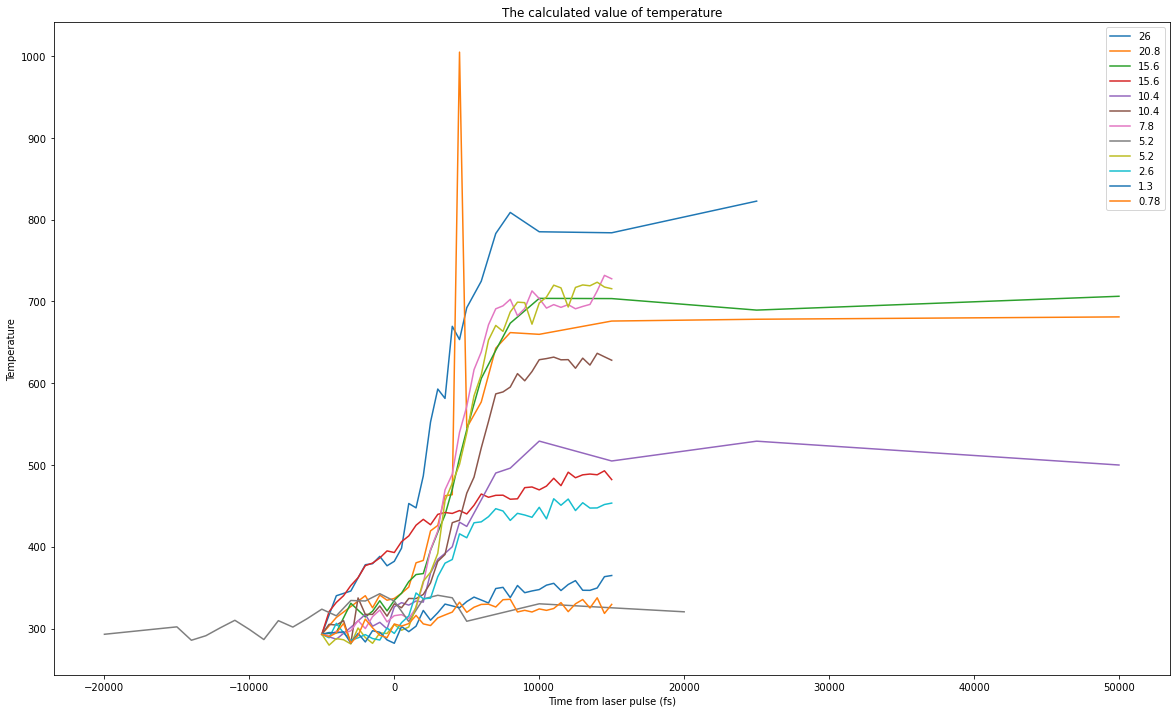

In [16]:
#Plotting the results

plt.figure(0, figsize = (20, 12))

plt.plot(np.array(dictionary_of_times['26']), dictionary_of_predictions['26'][0], label = '26')
plt.plot(np.array(dictionary_of_times['20.8']), dictionary_of_predictions['20.8'][0], label = '20.8')
plt.plot(np.array(dictionary_of_times['15.6 - 2']), dictionary_of_predictions['15.6 - 2'][0], label = '15.6')
plt.plot(np.array(dictionary_of_times['15.6 - 1']), dictionary_of_predictions['15.6 - 1'][0], label = '15.6')
plt.plot(np.array(dictionary_of_times['10.4 - 2']), dictionary_of_predictions['10.4 - 2'][0], label = '10.4')
plt.plot(np.array(dictionary_of_times['10.4 - 1']), dictionary_of_predictions['10.4 - 1'][0], label = '10.4')
plt.plot(np.array(dictionary_of_times['7.8']), dictionary_of_predictions['7.8'][0], label = '7.8')
plt.plot(np.array(dictionary_of_times['5.2 - 2']), dictionary_of_predictions['5.2 - 2'][0], label = '5.2')
plt.plot(np.array(dictionary_of_times['5.2 - 1']), dictionary_of_predictions['5.2 - 1'][0], label = '5.2')
plt.plot(np.array(dictionary_of_times['2.6']), dictionary_of_predictions['2.6'][0], label = '2.6')
plt.plot(np.array(dictionary_of_times['1.3']), dictionary_of_predictions['1.3'][0], label = '1.3')
plt.plot(np.array(dictionary_of_times['0.78']), dictionary_of_predictions['0.78'][0], label = '0.78')

plt.legend()
plt.xlabel('Time from laser pulse (fs)')
plt.ylabel('Temperature')
plt.title('The calculated value of temperature')

In [31]:
#Removing anomalous result

dictionary_of_predictions['20.8'][0][15]
dictionary_of_predictions['20.8'][0].pop(15)
dictionary_of_predictions['20.8'][1].pop(15)
dictionary_of_times['20.8'].pop(15)

1004.8567682113945

In [38]:
#This section of code saves every image (excluding the anomalous result) as a npy file, labelled by their uiso value for Dhruv

def temp_to_uiso(temp):
    """Inputs a temperature, ouputs the uiso value"""
    
    return B(temp)/(8*np.pi**2)

directory = 'D:\\Uni\\Year 4\\Research\\labelled_real_data\\'
    
for key in dictionary_of_predictions:
    pair = dictionary_of_predictions[key]
    
    for i in range(len(pair[0])):
        label = temp_to_uiso(pair[0][i])
        np.save(directory + str(label), pair[1][i])
        
#All other code from here on out classifies each image in terms of temperature, puts a stopper on them and saves them in folders
#corresponding to their class

In [42]:
temp_to_uiso(800)

0.039620686312091584

In [18]:
labels = [300 ,320 ,340, 360, 380, 400, 420, 440, 460, 480, 500, 550, 600, 650, 700, 800]

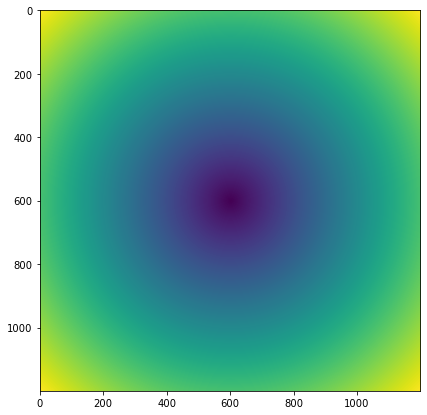

In [44]:
fake_resolution = 1200

xx, yy = np.mgrid[:fake_resolution, :fake_resolution]
circle = ((xx - fake_resolution/2) ** 2 + (yy - fake_resolution/2) ** 2)*0.05*2/(fake_resolution**2)

new_circ = np.sqrt(circle)
plt.figure(1, figsize = (7, 7))
plt.imshow(new_circ)

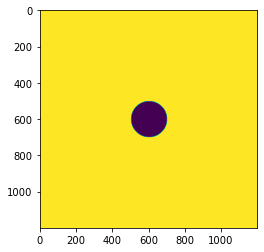

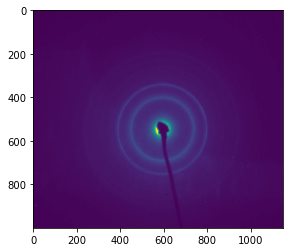

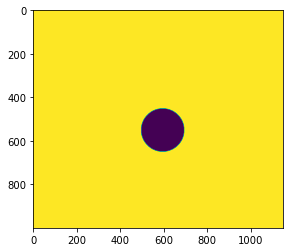

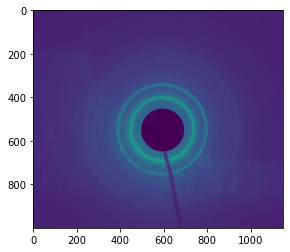

In [52]:
blocker = new_circ > 300/11500

modified_blocker = blocker[50:1050, 5:1153]

plt.figure(1)
plt.imshow(blocker)

plt.figure(2)
plt.imshow(dictionary_of_predictions['26'][1][1])

plt.figure(3)
plt.imshow(modified_blocker)

plt.figure(4)
plt.imshow(dictionary_of_predictions['26'][1][1] * modified_blocker)

 #   for i in range(10):
 #   modified_blocker.insert(0, blocker[0])
 #   modified_blocker.pop()

In [55]:
images_and_labels = []

for key in dictionary_of_predictions:
    temps = dictionary_of_predictions[key][0]
    imgs = dictionary_of_predictions[key][1]
    
    for i in range(len(temps)):
        
        #to revert back to non blocked images, delete '* modified_blocker'
        img = imgs[i] * modified_blocker

        if temps[i] < labels[0]:
            images_and_labels.append(((img/np.amax(img))*12000, '0'))
            
        if temps[i] >= labels[15]:
            images_and_labels.append(((img/np.amax(img))*12000, '16'))
            
        for j in range(0,15):
            if temps[i] < labels[j+1] and temps[i] >= labels[j]:
                images_and_labels.append(((img/np.amax(img))*12000, str(j+1)))

In [2]:
#Create the files if they don't already exist
import os
training_dir = 'D:\\Uni\\Year 4\\Research\\real_data_CNN\\Training\\'
validation_dir = 'D:\\Uni\\Year 4\\Research\\real_data_CNN\\Validation\\'

for i in range(0, 17):
    os.mkdir(training_dir + str(i))
    os.mkdir(validation_dir + str(i))

In [22]:
new_training_dir = 'D:\\Uni\\Year 4\\Research\\cGAN\\new_training\\'

for i in range(0, 17):
    os.mkdir(new_training_dir + str(i))

In [46]:
for i in range(len(images_and_labels)):
    image = Image.fromarray(images_and_labels[i][0].astype(int))
    
    if i%6 == 0:
        image.save(validation_dir + images_and_labels[i][1] + '\\' + str(i) + '.png')
            
    else:
        image.save(training_dir + images_and_labels[i][1] + '\\' + str(i) + '.png')


In [23]:
for i in range(len(images_and_labels)):
    image = Image.fromarray(images_and_labels[i][0].astype(int))
    image.save(new_training_dir + images_and_labels[i][1] + '\\' + str(i) + '.png')

In [59]:
stopper_training_dir = 'D:\\Uni\\Year 4\\Research\\cGAN\\stopper_training\\'

for i in range(len(images_and_labels)):
    image = Image.fromarray(images_and_labels[i][0].astype(int))
    image.save(stopper_training_dir + images_and_labels[i][1] + '\\' + str(i) + '.png')

In [104]:
#The rest of this code from here isn't necessary - it is just some data visualisation

predictions = create_prediction("2.21.2021 scan 13 f15.6")

Center(x,y):
588 574
Center(x,y):
600 574
Center(x,y):
593 572
Center(x,y):
593 574
Center(x,y):
597 573
Center(x,y):
601 572
Center(x,y):
589 574
Center(x,y):
593 574
Center(x,y):
601 572
Center(x,y):
593 572
Center(x,y):
593 572
Center(x,y):
588 574
Center(x,y):
593 573
Center(x,y):
600 574
Center(x,y):
600 574
Center(x,y):
588 574
Center(x,y):
588 573
Center(x,y):
594 574
Center(x,y):
588 573
Center(x,y):
597 572
Center(x,y):
597 572
Center(x,y):
593 572
Center(x,y):
584 573
Center(x,y):
587 572
Center(x,y):
587 573


<ipython-input-48-5bb24f60bffc>:8: RuntimeWarning: invalid value encountered in true_divide
  radialprofile = tbin / nr  # does this divide by number of pixels? Then it is truly average


Found solution after 1 iterations.
Found solution after 1 iterations.
Found solution after 1 iterations.
Found solution after 1 iterations.
Found solution after 1 iterations.
Found solution after 1 iterations.
Found solution after 1 iterations.
Found solution after 1 iterations.
Found solution after 1 iterations.
Found solution after 2 iterations.
Found solution after 2 iterations.
Found solution after 2 iterations.
Found solution after 2 iterations.
Found solution after 2 iterations.
Found solution after 2 iterations.
Found solution after 2 iterations.
Found solution after 2 iterations.
Found solution after 2 iterations.
Found solution after 2 iterations.
Found solution after 2 iterations.
Found solution after 2 iterations.
Found solution after 2 iterations.
Found solution after 2 iterations.
Found solution after 2 iterations.
Found solution after 2 iterations.


25


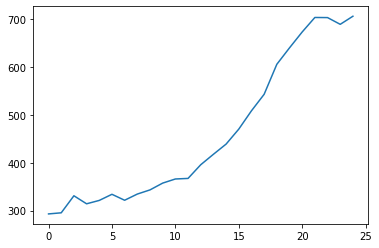

In [105]:
print(len(predictions))
plt.plot(np.arange(25), predictions)

In [37]:
img, x, y = preprocess_img("scan3_000002_GL-1_-05000_fs_On_   NaN_md_.tiff", "2.16.2021 scan 3 f5.2")

Center(x,y):
593 558


In [45]:
img_halved = img[0:y,:]

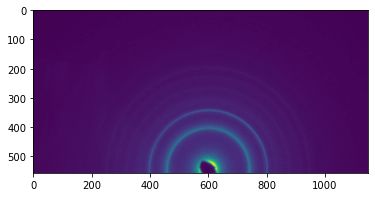

In [46]:
plt.imshow(img_halved)

In [49]:
radial = radialProfile(img, (x, y))
radial_halved = radialProfile(img_halved, (x, y))

<ipython-input-48-5bb24f60bffc>:8: RuntimeWarning: invalid value encountered in true_divide
  radialprofile = tbin / nr  # does this divide by number of pixels? Then it is truly average


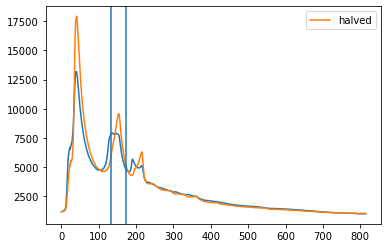

In [68]:
plt.figure(1)
plt.plot(np.arange(815), radial)
plt.plot(np.arange(815), radial_halved, label = 'halved')
plt.axvline(x=154+20)
plt.axvline(x=154-20)
plt.legend()

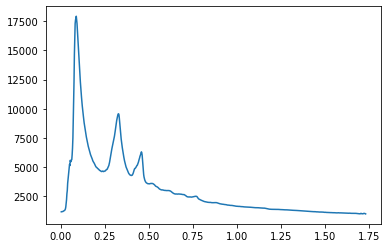

In [52]:
pixel_to_s = 2.126e-3
scattering_scale = pixel_to_s * np.arange(815)

plt.plot(scattering_scale, radial_halved)


In [58]:
np.argmax(radial_halved[100: 200])

54

In [62]:
print(radial_halved[154])

9571.394789579159


In [41]:
print(dictionary_of_predictions['26'][1])

[array([[1158, 1135, 1186, ..., 1314, 1282, 1271],
       [1171, 1163, 1176, ..., 1351, 1316, 1254],
       [1136, 1161, 1161, ..., 1289, 1287, 1260],
       ...,
       [1210, 1177, 1156, ..., 1194, 1178, 1163],
       [1235, 1187, 1179, ..., 1149, 1131, 1138],
       [1252, 1237, 1216, ..., 1183, 1139, 1128]], dtype=int16), array([[1223, 1182, 1199, ..., 1285, 1268, 1247],
       [1231, 1152, 1164, ..., 1318, 1295, 1241],
       [1228, 1147, 1128, ..., 1254, 1269, 1243],
       ...,
       [1240, 1232, 1218, ..., 1251, 1221, 1137],
       [1225, 1215, 1210, ..., 1194, 1158, 1125],
       [1220, 1218, 1219, ..., 1199, 1172, 1137]], dtype=int16), array([[1202, 1177, 1178, ..., 1275, 1224, 1234],
       [1156, 1146, 1130, ..., 1319, 1275, 1197],
       [1137, 1133, 1109, ..., 1228, 1266, 1250],
       ...,
       [1273, 1200, 1217, ..., 1194, 1138, 1124],
       [1283, 1215, 1219, ..., 1160, 1141, 1138],
       [1235, 1230, 1201, ..., 1190, 1168, 1200]], dtype=int16), array([[1160, 1113